# **Imports:**

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from PIL import Image
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import DepthwiseConv2D
from tensorflow.keras.layers import LeakyReLU

# **Data preprocessing** (Using CIFAR10 dataset)

In [66]:
# Loading data from cifar10 dataset
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

# normilizing data to [0 - 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0


# **Creating the autoencoder:**

### Encoder:

In [104]:
latentDim = 1024

encoderInput = Input(shape=(32, 32, 3))

X = Conv2D(64, (3, 3), strides=2, padding="same")(encoderInput)
X = BatchNormalization(axis=-1)(X)
X = LeakyReLU(alpha=0.3)(X)

X = DepthwiseConv2D((3, 3), strides=2, padding="same")(X)
X = BatchNormalization(axis=-1)(X)
X = LeakyReLU(alpha=0.3)(X)

X = Conv2D(128, (3, 3), strides=2, padding="same")(X)
X = BatchNormalization(axis=-1)(X)
X = LeakyReLU(alpha=0.3)(X) 

volumeSize = K.int_shape(X)
X = Flatten()(X)
X = Dense(latentDim)(X)

encoder = Model(encoderInput, X, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        1792      
_________________________________________________________________
batch_normalization_44 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
depthwise_conv2d_8 (Depthwis (None, 8, 8, 64)          640       
_________________________________________________________________
batch_normalization_45 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 8, 8, 64)          0   

### Decoder:

In [105]:
decoderInput = Input(shape=(latentDim,))
X = Dense(np.prod(volumeSize[1:]))(decoderInput)
X = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(X)

X = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(X)
X = BatchNormalization(axis=-1)(X)
X = LeakyReLU(alpha=0.3)(X)

X = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(X)
X = BatchNormalization(axis=-1)(X)
X = LeakyReLU(alpha=0.3)(X)

X = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(X)
X = BatchNormalization(axis=-1)(X)
X = LeakyReLU(alpha=0.3)(X)

X = Conv2DTranspose(3, (3, 3), padding="same", activation="sigmoid")(X)

decoder = Model(decoderInput, X, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_11 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 8, 8, 128)         147584    
_________________________________________________________________
batch_normalization_47 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 16, 16, 64)        7379

### Autoencoder:

In [106]:
autoencoder = Model(encoderInput, decoder(encoder(encoderInput)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder (Model)              (None, 1024)              2175488   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         2360259   
Total params: 4,535,747
Trainable params: 4,534,723
Non-trainable params: 1,024
_________________________________________________________________


# **Training:**

In [107]:
autoencoder.compile(loss="mse", optimizer="adam")

history = autoencoder.fit(train_x, train_x,
               validation_data=(test_x, test_x),
               epochs=20,
               batch_size=32)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 45s 891us/sample - loss: 0.0081 - val_loss: 0.0044
Epoch 2/20
50000/50000 [==============================] - 39s 789us/sample - loss: 0.0041 - val_loss: 0.0033
Epoch 3/20
50000/50000 [==============================] - 40s 795us/sample - loss: 0.0033 - val_loss: 0.0025
Epoch 4/20
50000/50000 [==============================] - 40s 796us/sample - loss: 0.0028 - val_loss: 0.0023
Epoch 5/20
50000/50000 [==============================] - 40s 800us/sample - loss: 0.0025 - val_loss: 0.0020
Epoch 6/20
50000/50000 [==============================] - 41s 817us/sample - loss: 0.0023 - val_loss: 0.0020
Epoch 7/20
50000/50000 [==============================] - 41s 810us/sample - loss: 0.0021 - val_loss: 0.0018
Epoch 8/20
50000/50000 [==============================] - 39s 771us/sample - loss: 0.0019 - val_loss: 0.0016
Epoch 9/20
50000/50000 [==============================] - 39s 772us/sample - l

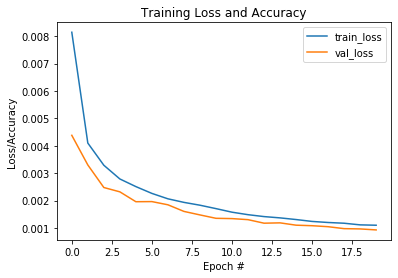

In [108]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

## Reconstructing some images :

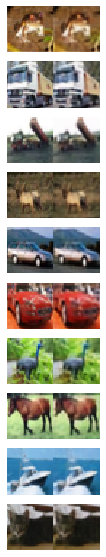

In [109]:
decoded = autoencoder.predict(train_x)

plt.figure(figsize=(10,10))
for i in range(0, 10):
    original = (train_x[i] * 255).astype("uint8")
    recon = (decoded[i] * 255).astype("uint8")
    plt.subplot(10, 1, i + 1)
    plt.imshow(np.hstack(np.squeeze([original, recon])))
    plt.axis("off")
plt.show()

# **Saving model:**

In [110]:
# serialize model to JSON
model_json = autoencoder.to_json()
with open("cbir-autoencoder.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights("cbir-autoencoder.h5")
print("Saved model to disk")

Saved model to disk


# Getting the latent-space of each image:
### We'll compare each latent-space with the query (euclidean distance)

In [111]:
features = encoder.predict(train_x)
queryIndex = np.random.randint(len(train_x))
query = features[queryIndex]
max_results = 20
results = []

for i in range(0, len(train_x)):
    delta = np.linalg.norm(query - features[i])
    results.append((delta, i))
    
results = sorted(results)[:max_results]

## Ploting results:
### Original query

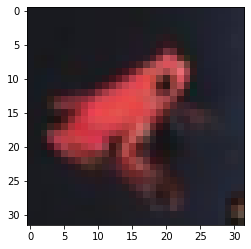

In [112]:
plt.imshow((train_x[queryIndex] * 255).astype("uint"))

### Results:

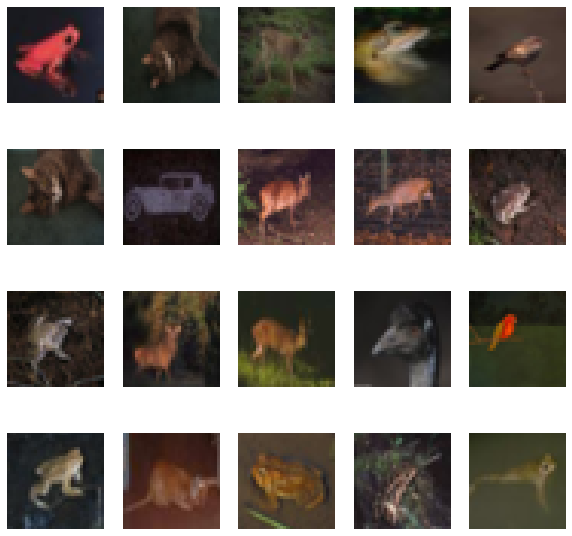

In [113]:
plt.figure(figsize=(10, 10))
for i in range(0, len(results)):
    plt.subplot(4, 5, i + 1)
    plt.imshow((train_x[results[i][1]] * 255).astype("uint8"))
    plt.axis("off")
plt.show()